# Preprocessing

In [1]:
import scipy.io as scio
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

Types of clustering:
- Affinity Propagation
- Agglomerative Clustering
- BIRCH
- DBSCAN
- K-Means
- Mini-Batch K-Means
- Mean Shift
- OPTICS
- Spectral Clustering
- Mixture of Gaussians

https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

## Get data - without baseline 
Removal method from Gniadecka

In [3]:
tissue3 = scio.loadmat('../Data/tissue3_1.mat')
tissue6 = scio.loadmat('../Data/tissue6.mat')
tissue30 = scio.loadmat('../Data/tissue30.mat')
tissue31 = scio.loadmat('../Data/tissue31.mat')
tissue34_1 = scio.loadmat('../Data/tissue34_1.mat')
tissue34_2 = scio.loadmat('../Data/tissue34_2.mat')
tissue36 = scio.loadmat('../Data/tissue36.mat')
tissue37 = scio.loadmat('../Data/tissue37.mat')
tissue39_1 = scio.loadmat('../Data/tissue39_1.mat')

calibration = scio.loadmat('../Data/cal_14.mat')
x = calibration['Cal'][0][0][0]
x = [item for sublist in x for item in sublist]

tissue_data = [tissue3,tissue6,tissue30,tissue31,tissue34_1,tissue34_2,tissue36,tissue37,tissue39_1]
file_names = ['map_t3_nobl.txt','map_t6_nobl.txt','map_t30_nobl.txt','map_t31_nobl.txt','map_t34_1_nobl.txt','map_t34_2_nobl.txt','map_t36_nobl.txt','map_t37_nobl.txt','map_t39_1_nobl.txt']

In [4]:
tissues = []
count = 0
for item in tissue_data: 
    t_IDX = item['IDX']
    t_bcc = item['bcc']
    width = t_bcc.shape[0]
    height = t_bcc.shape[1]
    t_map = np.loadtxt(file_names[count]).reshape(width*height,1024)
    tissues.append((t_map,t_bcc,t_IDX,width,height))
    count += 1
    
# tissues: (t_map, t_bcc, t_IDX, width, height)

In [5]:
## Train PCA only on relevant BCC data
pca_training_data = np.zeros((1000,1024))
count = 0

for tissue in tissues:
    for i in range(width):
        for j in range(height):
            if count < 1000:
                if tissue[1][i,j] == 1:
                    index = i*height + j
                    pca_training_data[count] = tissue[0][index,:]
                    count += 1

## PCA dimensionality reduction

In [6]:
# Fit PCA to data and transform all spectra    
norm_data = normalize(pca_training_data)
pca = PCA(n_components=200)
pca.fit(norm_data)

for i in range(len(tissues)): 
    transformed = pca.transform(tissues[i][0])
    tissues[i] = (transformed,tissues[i][1],tissues[i][2],tissues[i][3],tissues[i][4])
    

In [22]:
## Reshape to regain spatial information
new_tissues = []

for i in range(len(tissues)):
    (t_map,t_bcc,t_IDX,width,height) = tissues[i]
    new_map = np.zeros((width,height,200))
    
    for i in range(width):
        for j in range(height):
            index = i*height + j
            new_map[i,j,:] = t_map[index,:]
    
    new_tissues.append((new_map,t_bcc,t_IDX,width,height))

In [7]:
(X, bcc, IDX, width, height) = tissues[0]
X.shape

(40000, 200)

# Clustering tests

In [8]:
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering,Birch,DBSCAN,KMeans,MiniBatchKMeans,OPTICS,SpectralClustering,MeanShift
from sklearn.mixture import GaussianMixture

In [9]:
def show_labels(labels):
    print(labels.shape)
    res = labels.reshape(width,height)
    plt.imshow(res)

 ## Affinity Propagation

In [ ]:
af = AffinityPropagation(random_state=0).fit(X)
show_labels(af.labels_)

## Aglomerative clustering

(40000,)


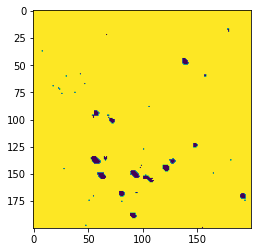

In [14]:
ac = AgglomerativeClustering().fit(X)
show_labels(ac.labels_)

## BIRCH

(40000,)


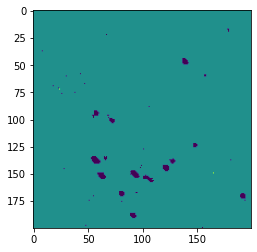

In [13]:
birch = Birch().fit(X)
labels = birch.predict(X)
show_labels(labels)

## DBSCAN

(40000,)


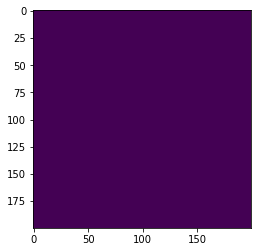

In [12]:
dbs = DBSCAN().fit(X)
show_labels(dbs.labels_)

## Mean shift

(40000,)


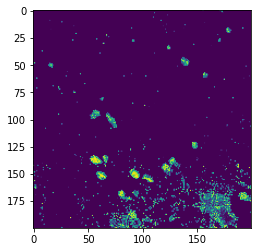

In [12]:
mshift = MeanShift().fit(X)
show_labels(mshift.labels_)

## K-Means

(40000,)


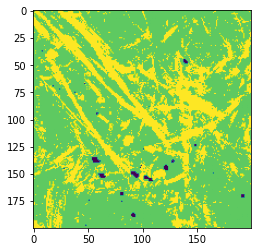

In [10]:
k = KMeans(n_clusters=5).fit(X)
show_labels(k.labels_)

## Mini-Batch K-Means

(40000,)


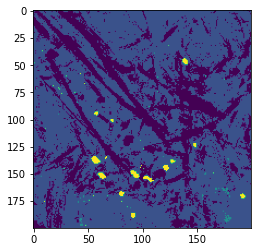

In [11]:
minik = MiniBatchKMeans(n_clusters=5,random_state=0).fit(X)
show_labels(minik.labels_)

## OPTICS

(40000,)


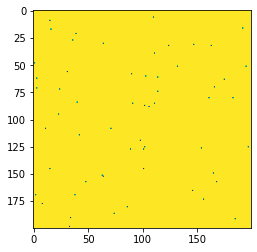

In [13]:
opt = OPTICS().fit(X)
show_labels(opt.labels_)

## Spectral Clustering

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(40000,)


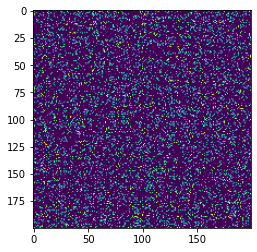

In [14]:
spec = SpectralClustering(random_state=0).fit(X)
show_labels(spec.labels_)

## Mixture of Gaussians

(40000,)


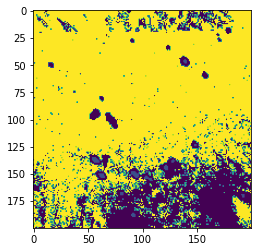

In [11]:
gm = GaussianMixture(n_components=5, random_state=0).fit(X)
show_labels(gm.predict(X))

# Best result - parameter tuning


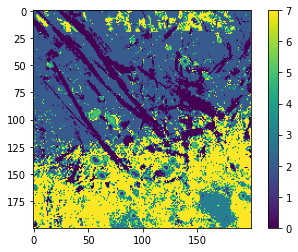

In [280]:
gm = GaussianMixture(n_components=6, random_state=0, covariance_type='spherical').fit(X)
gm_img = gm.predict(X).reshape(width,height)
plt.imshow(gm_img2)
plt.colorbar()

## Connected Components

In [106]:
from skimage.measure import label
connected, num_blobs = label(gm_img, background=5, return_num=True, connectivity=2)

In [286]:
def remove_small_large(data, blobs, minimum=6, maximum=100000, title='Processed'):
    """
    Remove small and large clusters. Set them to 0 (background).
    
    Args:
        data (np.array): connected component image
        blobs (int): number of clusters in data 
        minimum (int, optional): defaults to 6.
        maximum (int,optional): defaults to 100000.
        title (string, optional): image title. Defaults to 'Processed'.

    Returns:
        data_clean (np.array): connected component image without small or large clusters
        unique_blobs (int): number of clusters in data_clean 
    """
    small = []
    large = []
    
    for i in range(blobs):
        clust = (data == i)
        size = sum(sum(clust))
        
        if size < minimum:
            small.append(i)
        if size > maximum:
            large.append(i)
            
    data_clean = data.copy()
    for i in small:
        data_clean = np.where(data_clean==i, 0, data_clean) 
    for i in large:
        data_clean = np.where(data_clean==i, 0, data_clean) 
    
    # Change label numbering to consecutive numbers
    unique_blobs = np.unique(data_clean)
    count = 0
    for i in unique_blobs:
        data_clean = np.where(data_clean==i, count, data_clean) 
        count += 1
        
    _, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(data)
    axs[0].title.set_text('Original')
    axs[1].imshow(data_clean)
    axs[1].title.set_text(title)

    return data_clean, unique_blobs

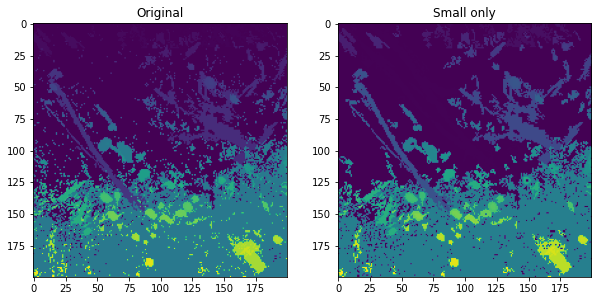

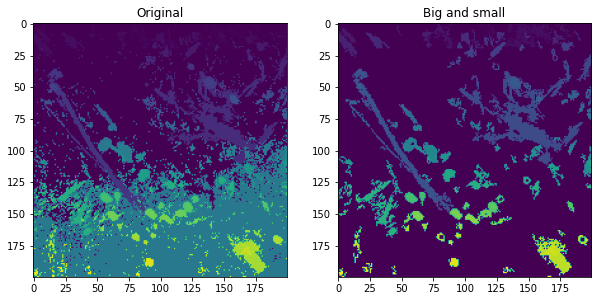

In [287]:
# Ignore only small
connected_clean, unique = remove_small_large(connected, num_blobs, title='Small only')
# Ignore small and large
connected_clean_nobig, unique_nobig = remove_small_large(connected, num_blobs, minimum=10, maximum=2000, title='Big and small')

## Option 1:

Get the average spectrum of each blob. Then perform clustering on those averaged spectra.

In [210]:
def get_avg_cluster(blobs, spectra):
    length = len(blobs)
    blob_avg_spectrum = np.zeros((length,200))

    for n in range(length):
        count = 0
        for i in range(width):
            for j in range(height):
                index = i*height + j
                if connected_clean[i,j] == n:
                    blob_avg_spectrum[n,:] += spectra[index,:]
                    count += 1
        blob_avg_spectrum[n,:] /= count
    
    return blob_avg_spectrum

In [211]:
blob_spectra = get_avg_cluster(unique, X)
blob_spectra_nobig = get_avg_cluster(unique_nobig, X)

Gaussian Mixture.... or K-Means...

In [290]:
def gaussian_kmeans(spectra, data_clean, blobs, components=5):
    gm_2 = GaussianMixture(n_components=components, random_state=0, covariance_type='spherical').fit(spectra)
    gm_blob = gm_2.predict(spectra) 

    km = KMeans(n_clusters=components, random_state=1).fit(spectra)
    labels = km.labels_
    
    final_img_gm = data_clean.copy()
    final_img_km = data_clean.copy()

    for n in range(len(blobs)):
        final_img_gm = np.where(final_img_gm==n, gm_blob[n], final_img_gm) 
        final_img_km = np.where(final_img_km==n, labels[n], final_img_km) 
        
    _, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(final_img_gm)
    axs[0].title.set_text('Gaussian Mixture')
    axs[1].imshow(final_img_km)
    axs[1].title.set_text('K-Means')
    
    return final_img_km

NOTE: results below change with every iteration if random_state is not set to an integer. Sometimes the bcc area is set appart from the background with 10 components, sometimes not.

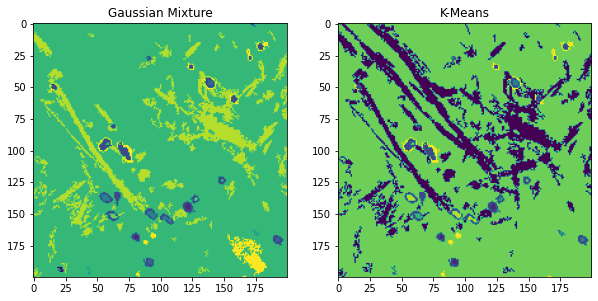

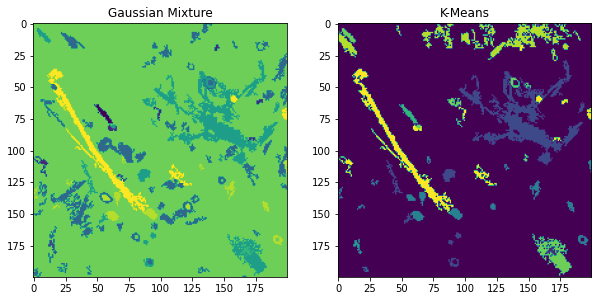

In [291]:
gaussian_kmeans(blob_spectra, connected_clean, unique, components=10)
res = gaussian_kmeans(blob_spectra_nobig, connected_clean_nobig, unique_nobig, components=10)

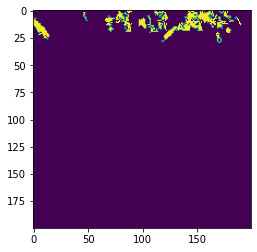

In [258]:
plt.imshow(res==8)

## Option 2:

Classify connected components clusters (not too small or big) from initial mixture of gaussians.

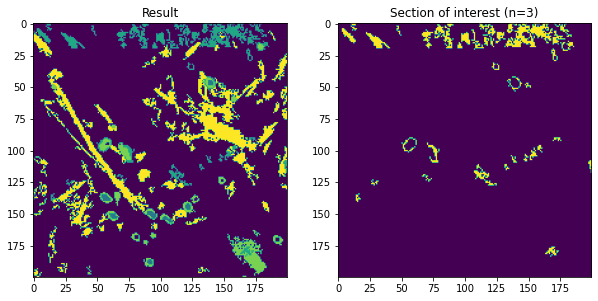

In [293]:
clusters = connected_clean_nobig > 0
final_clusters = clusters * np.abs(gm_img-5)

_, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(final_clusters)
axs[0].title.set_text('Result')
axs[1].imshow(final_clusters == 3)
axs[1].title.set_text('Section of interest (n=3)')
